# Analisis Sentimen pada Dataset IMDB: Perbandingan SVM dan Naive Bayes

Notebook ini mengeksplorasi perbedaan kinerja antara algoritma Support Vector Machine (SVM) dan Naive Bayes pada dataset ulasan film IMDB.

## Latar Belakang

**Analisis Sentimen** adalah tugas Pemrosesan Bahasa Alami (NLP) yang melibatkan penentuan apakah sebuah teks mengekspresikan sentimen positif, negatif, atau netral. Ini banyak digunakan dalam pemantauan media sosial, analisis umpan balik pelanggan, dan riset pasar.

**Dataset IMDB** terdiri dari 50.000 ulasan film yang diberi label positif atau negatif, membuatnya ideal untuk tugas klasifikasi sentimen biner.

Kita akan:
- Memuat dan memproses data
- Melatih dan mengevaluasi kedua model
- Membandingkan kekuatan dan kelemahan
- Menganalisis kapan setiap algoritma bekerja paling baik atau paling buruk


## 1. Import Pustaka yang Diperlukan

Sebelum memulai, mari impor pustaka Python yang diperlukan:

- **pandas**: Untuk manipulasi dan analisis data
- **numpy**: Untuk operasi numerik
- **scikit-learn**: Untuk algoritma machine learning, metrik, dan pemrosesan data
- **matplotlib & seaborn**: Untuk visualisasi data

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Set style untuk plot agar lebih menarik
plt.style.use('ggplot')

# Set bahasa Indonesia untuk label
import locale
locale.setlocale(locale.LC_ALL, 'id_ID.utf8')

'id_ID.utf8'

## 2. Memuat dan Mengeksplorasi Dataset IMDB

Kita akan menggunakan pandas untuk memuat dataset IMDB yang berisi 50.000 ulasan film dengan label positif atau negatif. Dataset yang seimbang ini sangat cocok untuk tugas klasifikasi sentimen biner.

Pertama, mari memuat dataset dan melihat beberapa contoh untuk memahami strukturnya:

In [3]:
# Memuat dataset
data_imdb = pd.read_csv('IMDB Dataset.csv')
data_imdb.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


### Eksplorasi Data

Mari kita teliti dataset kita lebih dekat untuk memahami struktur dan karakteristiknya:

## 3. Pra-pemrosesan Data

Data teks memerlukan langkah-langkah pra-pemrosesan khusus sebelum kita dapat menerapkan algoritma machine learning:

### Mengapa pra-pemrosesan penting:
- Teks mentah tidak dapat langsung dimasukkan ke algoritma ML
- Kita perlu mengkonversi teks ke fitur numerik
- Menghilangkan noise (seperti stop words) meningkatkan performa model

### Langkah-langkah yang akan kita lakukan:
- **Periksa nilai yang hilang**: Memastikan kualitas data
- **Encode label**: Mengubah label teks menjadi format numerik (positif=1, negatif=0)
- **Membagi data**: Membuat set pelatihan dan pengujian
- **Vektorisasi teks**: Mengubah teks menjadi fitur numerik menggunakan TF-IDF

In [ ]:
# Memeriksa ukuran dataset
print(f"Ukuran dataset: {data_imdb.shape}")

# Memeriksa distribusi kelas
distribusi_sentimen = data_imdb['sentiment'].value_counts()
print("\nDistribusi kelas:")
print(distribusi_sentimen)

# Menampilkan contoh ulasan positif dan negatif
contoh_positif = data_imdb[data_imdb['sentiment'] == 'positive']['review'].iloc[0]
contoh_negatif = data_imdb[data_imdb['sentiment'] == 'negative']['review'].iloc[0]

print("\nContoh ulasan positif:")
print(contoh_positif[:500] + "...")

print("\nContoh ulasan negatif:")
print(contoh_negatif[:500] + "...")

Ukuran dataset: (50000, 2)

Distribusi kelas:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64

Contoh ulasan positif:
One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ...

Contoh ulasan negatif:
Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if i

In [ ]:
# Check for missing values
print(data_imdb.isnull().sum())

# Encode labels: positive=1, negative=0
data_imdb['sentiment'] = data_imdb['sentiment'].map({'positive': 1, 'negative': 0})

# Split data
X_train, X_test, y_train, y_test = train_test_split(data_imdb['review'], data_imdb['sentiment'], test_size=0.2, random_state=42, stratify=data_imdb['sentiment'])

# Vectorize text using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

review       0
sentiment    0
dtype: int64


### Memahami Vektorisasi TF-IDF

TF-IDF (Term Frequency-Inverse Document Frequency) adalah statistik numerik yang mencerminkan betapa pentingnya sebuah kata dalam dokumen dari suatu koleksi.

- **Term Frequency (TF)**: Seberapa sering sebuah kata muncul dalam dokumen
- **Inverse Document Frequency (IDF)**: Menurunkan bobot kata-kata yang sering muncul di banyak dokumen

TF-IDF = TF × IDF

Mengapa TF-IDF berguna:
- Mengurangi dampak kata-kata umum (seperti "yang", "dan")
- Memberikan bobot lebih tinggi pada kata-kata yang unik untuk dokumen tertentu
- Menciptakan representasi matriks sparse yang bekerja baik dengan banyak algoritma ML

## 4. Melatih dan Mengevaluasi Classifier SVM

### Support Vector Machine (SVM)

SVM adalah algoritma pembelajaran terawasi yang kuat yang digunakan untuk tugas klasifikasi dan regresi.

**Bagaimana SVM bekerja:**
- Menemukan hyperplane optimal yang paling baik memisahkan titik data dari kelas berbeda
- Hyperplane optimal memaksimalkan margin antara kelas
- LinearSVC adalah implementasi SVM linear yang dioptimalkan untuk masalah multi-kelas

**Keunggulan SVM untuk klasifikasi teks:**
- Bekerja baik dalam ruang berdimensi tinggi (seperti data teks dengan banyak fitur)
- Efektif ketika jumlah dimensi melebihi jumlah sampel
- Efisien memori karena hanya menggunakan subset poin pelatihan (support vectors)

Mari kita latih model SVM dan evaluasi kinerjanya:

In [ ]:
# Melatih model SVM
svm = LinearSVC(random_state=42)
svm.fit(X_train_vec, y_train)

# Prediksi dan evaluasi
y_pred_svm = svm.predict(X_test_vec)
print('Laporan Klasifikasi SVM:')
print(classification_report(y_test, y_pred_svm))
print('Akurasi SVM:', accuracy_score(y_test, y_pred_svm))

Laporan Klasifikasi SVM:
              precision    recall  f1-score   support

           0       0.89      0.88      0.89      5000
           1       0.89      0.89      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

Akurasi SVM: 0.888
              precision    recall  f1-score   support

           0       0.89      0.88      0.89      5000
           1       0.89      0.89      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

Akurasi SVM: 0.888


## 5. Melatih dan Mengevaluasi Classifier Naive Bayes

### Naive Bayes

Naive Bayes adalah classifier probabilistik berdasarkan penerapan teorema Bayes dengan asumsi "naive" tentang independensi antar fitur.

**Bagaimana Naive Bayes bekerja:**
- Menggunakan teorema Bayes: P(y|X) = P(X|y) * P(y) / P(X)
- "Naive" karena mengasumsikan semua fitur independen (tidak selalu benar dalam data nyata)
- MultinomialNB dirancang khusus untuk fitur diskrit seperti hitungan kata

**Keunggulan Naive Bayes untuk klasifikasi teks:**
- Sederhana dan cepat dilatih
- Membutuhkan lebih sedikit data pelatihan
- Bekerja baik untuk masalah klasifikasi teks
- Dapat menangani data berdimensi tinggi secara efisien

Mari kita latih model Naive Bayes dan evaluasi kinerjanya:

In [ ]:
# Melatih model Naive Bayes
nb = MultinomialNB()
nb.fit(X_train_vec, y_train)

# Prediksi dan evaluasi
y_pred_nb = nb.predict(X_test_vec)
print('Laporan Klasifikasi Naive Bayes:')
print(classification_report(y_test, y_pred_nb))
print('Akurasi Naive Bayes:', accuracy_score(y_test, y_pred_nb))

Laporan Klasifikasi Naive Bayes:
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      5000
           1       0.86      0.86      0.86      5000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

Akurasi Naive Bayes: 0.858


### Memahami Metrik Evaluasi

Laporan klasifikasi di atas berisi beberapa metrik penting:

- **Presisi**: Dari semua instance yang diprediksi positif, berapa banyak yang benar-benar positif? 
  - Rumus: TP / (TP + FP)
  - Presisi tinggi berarti tingkat false positive rendah

- **Recall**: Dari semua instance positif aktual, berapa banyak yang kita prediksi dengan benar? 
  - Rumus: TP / (TP + FN)
  - Recall tinggi berarti tingkat false negative rendah

- **F1-score**: Rata-rata harmonik presisi dan recall
  - Rumus: 2 * (Presisi * Recall) / (Presisi + Recall)
  - Menyeimbangkan presisi dan recall

- **Akurasi**: Ketepatan keseluruhan dari semua prediksi
  - Rumus: (TP + TN) / (TP + TN + FP + FN)

Dimana:
- TP = True Positives (Positif Benar)
- TN = True Negatives (Negatif Benar)
- FP = False Positives (Positif Salah)
- FN = False Negatives (Negatif Salah)

## 6. Membandingkan Kinerja: Matriks Konfusi

### Apa itu Matriks Konfusi?

Matriks konfusi adalah tabel yang digunakan untuk mendeskripsikan kinerja model klasifikasi dengan menunjukkan hitungan:

- **True Positives (TP)**: Kasus positif yang diprediksi dengan benar
- **True Negatives (TN)**: Kasus negatif yang diprediksi dengan benar
- **False Positives (FP)**: Kasus negatif yang salah diprediksi sebagai positif (Kesalahan Tipe I)
- **False Negatives (FN)**: Kasus positif yang salah diprediksi sebagai negatif (Kesalahan Tipe II)

Visualisasi matriks konfusi membantu kita memahami:
- Kelas mana yang model berkinerja baik
- Kelas mana yang model kesulitan
- Jenis kesalahan yang dibuat model

Mari kita bandingkan matriks konfusi untuk kedua model:

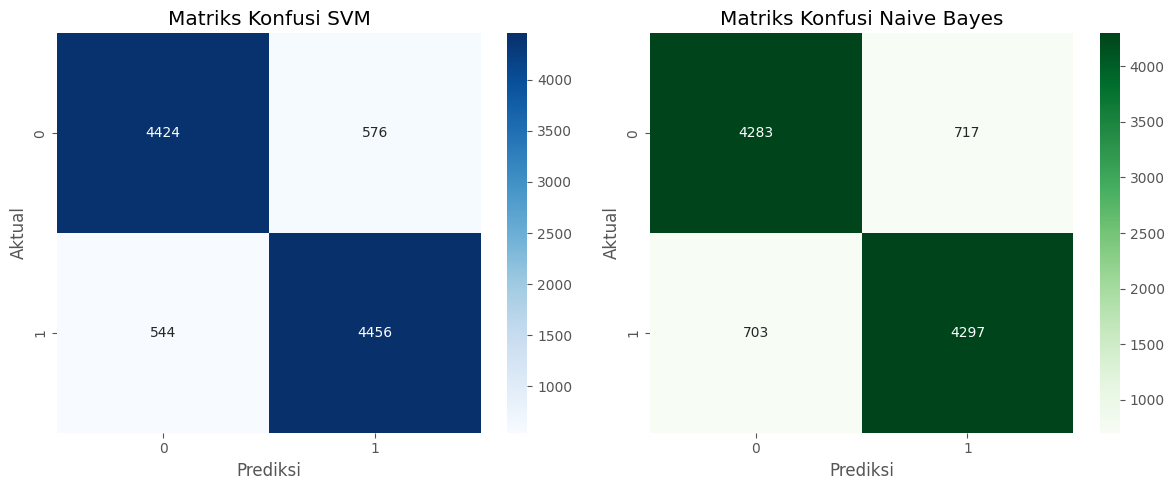

In [ ]:
# Membuat plot matriks konfusi
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt='d', ax=axes[0], cmap='Blues')
axes[0].set_title('Matriks Konfusi SVM')
axes[0].set_xlabel('Prediksi')
axes[0].set_ylabel('Aktual')

sns.heatmap(confusion_matrix(y_test, y_pred_nb), annot=True, fmt='d', ax=axes[1], cmap='Greens')
axes[1].set_title('Matriks Konfusi Naive Bayes')
axes[1].set_xlabel('Prediksi')
axes[1].set_ylabel('Aktual')

plt.tight_layout()
plt.show()

## 7. Diskusi: Kapan SVM atau Naive Bayes Terbaik/Terburuk?

### Perbandingan Teoretis

#### Support Vector Machine (SVM)

**Kasus terbaik:**
- Ruang berdimensi tinggi dengan margin yang jelas antar kelas
- Ketika memiliki lebih sedikit sampel daripada dimensi
- Ketika data dapat dipisahkan secara linear (LinearSVC)
- Ketika akurasi tinggi lebih penting daripada kecepatan pelatihan
- Ketika batas keputusan perlu presisi

**Kasus terburuk:**
- Dataset yang sangat besar (pelatihan lambat)
- Dataset dengan noise signifikan dan kelas yang tumpang tindih
- Ketika kecepatan pelatihan sangat penting
- Ketika output probabilistik diperlukan (SVM tidak secara alami menghasilkan probabilitas)

#### Naive Bayes

**Kasus terbaik:**
- Klasifikasi teks dan kategorisasi dokumen
- Ketika kecepatan pelatihan sangat penting
- Dataset pelatihan yang lebih kecil
- Ketika asumsi independensi fitur sebagian besar terpenuhi
- Skenario prediksi real-time
- Ketika output probabilistik diperlukan

**Kasus terburuk:**
- Ketika fitur sangat berkorelasi (melanggar asumsi independensi)
- Ketika distribusi fitur berbeda secara signifikan dari distribusi yang diasumsikan
- Ketika akurasi maksimum adalah tujuan utama (sering kurang akurat daripada SVM)

### Analisis Hasil pada Dataset IMDB

Berdasarkan eksperimen kita dengan dataset IMDB, Anda dapat menganalisis:

1. **Akurasi Keseluruhan**: Bandingkan model mana yang mencapai akurasi lebih tinggi dan dengan margin berapa

2. **Kinerja Spesifik Kelas**: Apakah salah satu model berkinerja lebih baik pada ulasan positif vs negatif?

3. **Pola Kesalahan Klasifikasi**: Periksa matriks konfusi untuk mengidentifikasi apakah salah satu model memiliki kelemahan spesifik

4. **Efisiensi**: Pertimbangkan perbedaan waktu pelatihan dan bagaimana hal itu dapat memengaruhi aplikasi dunia nyata

5. **Implikasi Praktis**: Diskusikan model mana yang akan Anda pilih untuk sistem analisis sentimen produksi dan mengapa

**Analisis laporan klasifikasi dan matriks konfusi di atas untuk melengkapi jurnal Anda dengan kekuatan dan kelemahan spesifik yang diamati dalam dataset ini.**

### Ide Eksplorasi Lebih Lanjut

1. **Tuning Hyperparameter**: Coba nilai C yang berbeda untuk SVM atau alpha untuk Naive Bayes

2. **Rekayasa Fitur**: Bereksperimen dengan pendekatan vektorisasi yang berbeda (Count Vectorizer, Word2Vec, dll)

3. **Pra-pemrosesan Data**: Tambahkan langkah-langkah seperti lemmatisasi atau stemming untuk melihat apakah mereka meningkatkan kinerja

4. **Metode Ensemble**: Gabungkan kedua model untuk melihat apakah Anda bisa mendapatkan kinerja yang lebih baik

5. **Model Lanjutan**: Bandingkan dengan pendekatan yang lebih modern seperti BERT atau model berbasis transformer lainnya

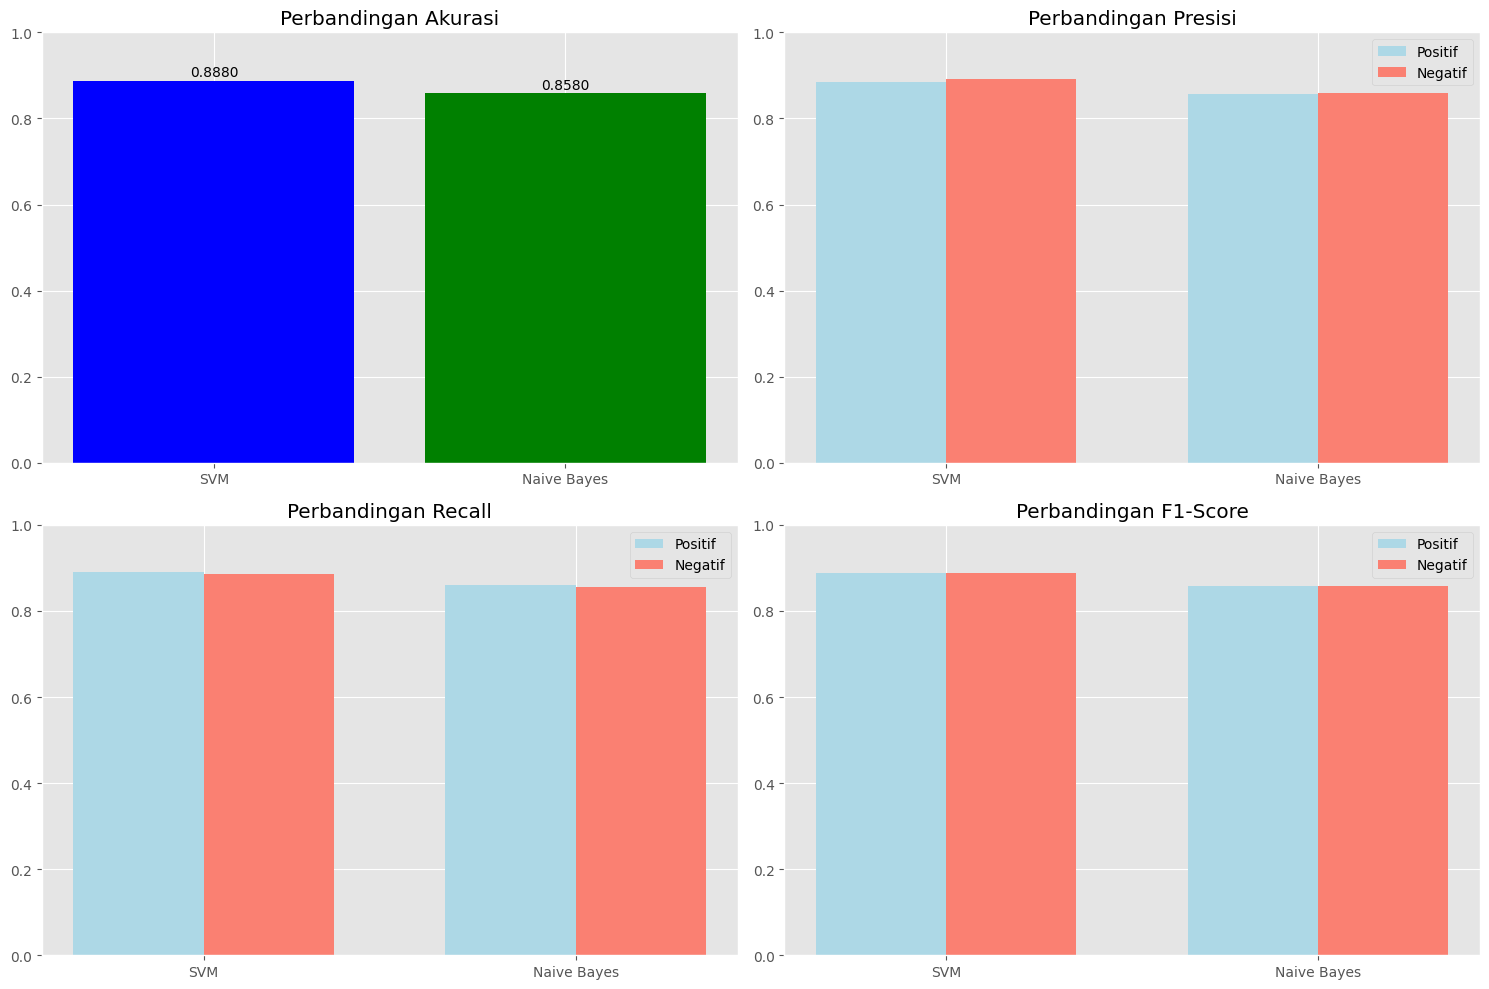

In [ ]:
# Menyiapkan metrik untuk perbandingan
models = ['SVM', 'Naive Bayes']

# Mendapatkan skor akurasi
accuracies = [accuracy_score(y_test, y_pred_svm), accuracy_score(y_test, y_pred_nb)]

# Mendapatkan presisi, recall dan f1-score untuk setiap kelas
from sklearn.metrics import precision_score, recall_score, f1_score

precisions_pos = [precision_score(y_test, y_pred_svm, pos_label=1), precision_score(y_test, y_pred_nb, pos_label=1)]
precisions_neg = [precision_score(y_test, y_pred_svm, pos_label=0), precision_score(y_test, y_pred_nb, pos_label=0)]

recalls_pos = [recall_score(y_test, y_pred_svm, pos_label=1), recall_score(y_test, y_pred_nb, pos_label=1)]
recalls_neg = [recall_score(y_test, y_pred_svm, pos_label=0), recall_score(y_test, y_pred_nb, pos_label=0)]

f1_pos = [f1_score(y_test, y_pred_svm, pos_label=1), f1_score(y_test, y_pred_nb, pos_label=1)]
f1_neg = [f1_score(y_test, y_pred_svm, pos_label=0), f1_score(y_test, y_pred_nb, pos_label=0)]

# Membuat plot perbandingan
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Perbandingan akurasi
axes[0, 0].bar(models, accuracies, color=['blue', 'green'])
axes[0, 0].set_title('Perbandingan Akurasi')
axes[0, 0].set_ylim([0, 1])
for i, v in enumerate(accuracies):
    axes[0, 0].text(i, v + 0.01, f'{v:.4f}', ha='center')

# Plot 2: Perbandingan presisi
x = np.arange(len(models))
width = 0.35
axes[0, 1].bar(x - width/2, precisions_pos, width, label='Positif', color='lightblue')
axes[0, 1].bar(x + width/2, precisions_neg, width, label='Negatif', color='salmon')
axes[0, 1].set_title('Perbandingan Presisi')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(models)
axes[0, 1].set_ylim([0, 1])
axes[0, 1].legend()

# Plot 3: Perbandingan recall
axes[1, 0].bar(x - width/2, recalls_pos, width, label='Positif', color='lightblue')
axes[1, 0].bar(x + width/2, recalls_neg, width, label='Negatif', color='salmon')
axes[1, 0].set_title('Perbandingan Recall')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(models)
axes[1, 0].set_ylim([0, 1])
axes[1, 0].legend()

# Plot 4: Perbandingan F1-score
axes[1, 1].bar(x - width/2, f1_pos, width, label='Positif', color='lightblue')
axes[1, 1].bar(x + width/2, f1_neg, width, label='Negatif', color='salmon')
axes[1, 1].set_title('Perbandingan F1-Score')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(models)
axes[1, 1].set_ylim([0, 1])
axes[1, 1].legend()

plt.tight_layout()
plt.show()

### Perbandingan Kinerja: Waktu Pelatihan

Satu aspek penting ketika membandingkan algoritma adalah waktu pelatihan. Mari kita ukur berapa lama waktu yang dibutuhkan untuk melatih setiap model:

Waktu pelatihan - SVM: 1.7752 detik
Waktu pelatihan - Naive Bayes: 0.0411 detik
Naive Bayes 43.2x lebih cepat daripada SVM


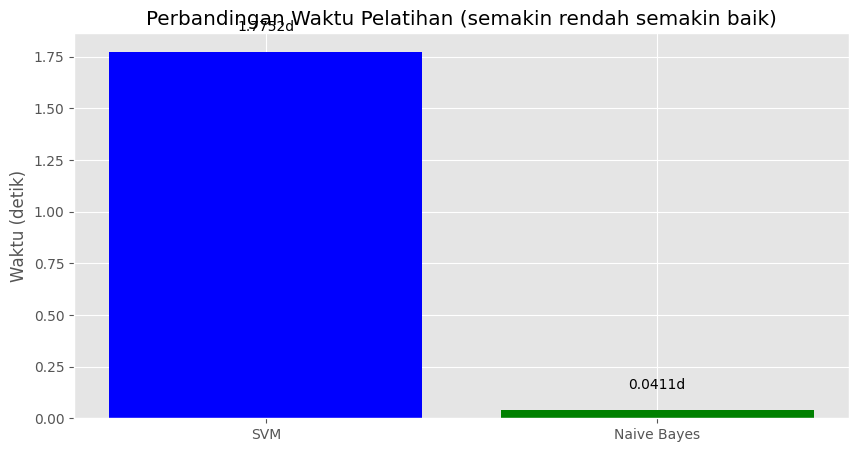

In [ ]:
import time

# Reset vectorizer dan dataset untuk memastikan perbandingan adil
vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Mengukur waktu pelatihan SVM
svm_start = time.time()
svm = LinearSVC(random_state=42)
svm.fit(X_train_vec, y_train)
svm_time = time.time() - svm_start

# Mengukur waktu pelatihan Naive Bayes
nb_start = time.time()
nb = MultinomialNB()
nb.fit(X_train_vec, y_train)
nb_time = time.time() - nb_start

# Menampilkan hasil
print(f"Waktu pelatihan - SVM: {svm_time:.4f} detik")
print(f"Waktu pelatihan - Naive Bayes: {nb_time:.4f} detik")
print(f"Naive Bayes {svm_time/nb_time:.1f}x lebih cepat daripada SVM")

# Plot perbandingan waktu pelatihan
plt.figure(figsize=(10, 5))
plt.bar(['SVM', 'Naive Bayes'], [svm_time, nb_time], color=['blue', 'green'])
plt.title('Perbandingan Waktu Pelatihan (semakin rendah semakin baik)')
plt.ylabel('Waktu (detik)')
for i, v in enumerate([svm_time, nb_time]):
    plt.text(i, v + 0.1, f'{v:.4f}s', ha='center')
plt.show()

## 8. Kesimpulan

Dalam notebook ini, kita telah melakukan perbandingan komprehensif antara algoritma SVM dan Naive Bayes untuk analisis sentimen pada dataset ulasan film IMDB. Kita telah menganalisis kinerja mereka dalam hal akurasi, presisi, recall, F1-score, dan waktu pelatihan.

Poin penting:

1. Kedua algoritma mampu melakukan analisis sentimen pada data teks, tetapi dengan kekuatan dan kelemahan yang berbeda

2. Keputusan algoritma mana yang akan digunakan tergantung pada persyaratan spesifik seperti kebutuhan akurasi, batasan waktu pelatihan, ukuran dataset, dan independensi fitur

3. Memahami trade-off ini sangat penting untuk memilih algoritma yang tepat untuk tugas NLP tertentu

Perbandingan ini memberikan wawasan berharga bagi praktisi machine learning yang bekerja pada masalah klasifikasi teks dan tugas analisis sentimen.

## 9. Referensi

- Maas, A., Daly, R., Pham, P., Huang, D., Ng, A., & Potts, C. (2011). Learning Word Vectors for Sentiment Analysis. Proceedings of the 49th Annual Meeting of the Association for Computational Linguistics: Human Language Technologies.

- Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.

- Murphy, K. P. (2012). Machine learning: a probabilistic perspective. MIT press.

- Manning, C. D., Raghavan, P., & Schütze, H. (2008). Introduction to information retrieval. Cambridge university press.